# Parsing the TISSUES resource

The TISSUES databse contains tissue-specific gene presence. For more information, see the TISSUES [publication](https://dx.doi.org/10.7717/peerj.1054), [website](http://tissues.jensenlab.org/Downloads), or [Thinklab discussion](http://thinklab.com/d/91).

In [1]:
# # Download TISSUES data files
# base_url = 'http://download.jensenlab.org/'
# filenames = [
#     'human_tissue_knowledge_filtered.tsv',
#     'human_tissue_knowledge_full.tsv',
#     'human_tissue_experiments_filtered.tsv',
#     'human_tissue_experiments_full.tsv',
#     'human_tissue_textmining_filtered.tsv',
#     'human_tissue_textmining_full.tsv',
#     'human_tissue_integrated_full.tsv',
# ]

# for filename in filenames:
#     ! wget --no-verbose --timestamping --directory-prefix download/ {base_url}/{filename}
#     ! gzip -f download/{filename}

In [2]:
# # Download STRING ensembl protein to entrez gene mapping
# url = 'ftp://string-db.org/STRING/10.0/mapping_files/entrez_mappings/entrez_gene_id.vs.string.v10.28042015.tsv'
# ! wget --no-verbose --timestamping --directory-prefix download/ {url}

In [3]:
import gzip

import pandas
import numpy
import matplotlib.pyplot
import seaborn

%matplotlib inline

## combining scoring

In [4]:
def meta_score(scores):
    """
    Combines scores, which range form 0 to 5, into a single
    integrated score. Learn more at http://thinklab.com/d/91#7
    """
    scores = numpy.array(scores, dtype='float')
    probs = scores / 5
    prob = 1 - numpy.prod(1 - probs)
    score = 5 * prob
    return score

## terminology terms

In [5]:
# Read entrez genes
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/6e133f9ef8ce51a4c5387e58a6cc97564a66cec8/data/genes-human.tsv'
entrez_df = pandas.read_table(url)    
entrez_df = entrez_df[['GeneID', 'Symbol']].rename(columns={'GeneID': 'entrez_gene_id', 'Symbol': 'gene_symbol'})

In [6]:
# Read uberon anatomy terms
url = 'https://raw.githubusercontent.com/dhimmel/uberon/e8dd9247779ba9c419e74ca4ae62e44df92657c3/data/terms.tsv'
uberon_df = pandas.read_table(url)

## terminology mappings

In [7]:
# Read Ensembl protein to Entrez Gene mappings
entrez_map_df = pandas.read_table('download/entrez_gene_id.vs.string.v10.28042015.tsv')
entrez_map_df.columns = 'entrez_gene_id', 'ensembl_protein_id'
entrez_map_df.ensembl_protein_id = entrez_map_df.ensembl_protein_id.map(lambda x: x.split('.')[1])

In [8]:
# Read BTO to Uberon cross-references
url = 'https://raw.githubusercontent.com/dhimmel/uberon/e8dd9247779ba9c419e74ca4ae62e44df92657c3/data/xref.tsv'
uberon_map_df = pandas.read_table(url)
uberon_map_df = uberon_map_df[uberon_map_df.xref.str.startswith('BTO:')]
uberon_map_df = uberon_map_df.rename(columns={'xref': 'bto_id'})

## dataset formats

Correspondence from Lars Juhl Jensen:

Regarding the file formats, the knowledge and experiments have the following format (columns enumerated):

1. Gene/protein ID (ENSP for proteins, other IDs for ncRNAs)
2. Human readable name for the gene/protein (HGNC gene symbol when available)
3. Brenda Tissue Ontology term
4. Human readable name for the BTO term
5. Source of evidence
6. Association support (can be a GO evidence code, number of ESTs, anything - the original evidence)
7. Confidence score (the score which is shown as stars in the web interface (rounded up on web pages))

The textmining files are a bit different; the first four columns are the same, followed by:
5. Co-occurrence Z-score
6. Confidence score (stars, comparable to other files)
7. Linkout for showing the abstracts that the association is based on


## textmining dataset

In [9]:
# Read TISSUES data
column_names = ['ensembl_protein_id', 'gene_symbol', 'bto_id', 'bto_name', 'z-score', 'score', 'sources']
text_df = pandas.read_table('download/human_tissue_textmining_full.tsv.gz', names=column_names)
text_df.head(2)

,ensembl_protein_id,gene_symbol,bto_id,bto_name,z-score,score,sources
0,5S_rRNA,5S_rRNA,BTO:0001481,Plant,4.614,2.3,http://tissues.jensenlab.org/Entity?documents=...
1,5S_rRNA,5S_rRNA,BTO:0000000,"tissues, cell types and enzyme sources",4.531,2.3,http://tissues.jensenlab.org/Entity?documents=...


In [10]:
# Add Uberon and Entrez Gene identifiers
text_df = text_df.merge(entrez_map_df).merge(uberon_map_df)
text_df.duplicated(['uberon_id', 'entrez_gene_id']).value_counts()

False    621980
True       9935
dtype: int64

In [11]:
# Collapse to uberon-entrez_gene pairs
text_df = text_df.groupby(['uberon_id', 'entrez_gene_id'])['score'].mean().reset_index()
text_df.head(2)

,uberon_id,entrez_gene_id,score
0,UBERON:0000002,2,0.8
1,UBERON:0000002,19,0.6


## knowledge dataset

In [12]:
# Read TISSUES data
column_names = ['ensembl_protein_id', 'gene_symbol', 'bto_id', 'bto_name', 'source', 'evidence', 'score']
knowledge_df = pandas.read_table('download/human_tissue_knowledge_full.tsv.gz', names=column_names)
knowledge_df.head(2)

,ensembl_protein_id,gene_symbol,bto_id,bto_name,source,evidence,score
0,ENSP00000000233,ARF5,BTO:0000000,"tissues, cell types and enzyme sources",UniProtKB-RC,CURATED,4
1,ENSP00000000233,ARF5,BTO:0000000,"tissues, cell types and enzyme sources",UniProtKB-RC,CURATED,4


In [13]:
# Add Uberon and Entrez Gene identifiers and collapse to uberon-entrez_gene pairs
knowledge_df = knowledge_df.merge(entrez_map_df).merge(uberon_map_df)
knowledge_df = knowledge_df.groupby(['uberon_id', 'entrez_gene_id'])['score'].mean().reset_index()
knowledge_df.head(2)

,uberon_id,entrez_gene_id,score
0,UBERON:0000002,218,4
1,UBERON:0000002,226,4


## experimental dataset

In [14]:
# Read TISSUES data
column_names = ['ensembl_protein_id', 'gene_symbol', 'bto_id', 'bto_name', 'source', 'evidence', 'score']
experiment_df = pandas.read_table('download/human_tissue_experiments_full.tsv.gz', names=column_names)
experiment_df.head(2)

,ensembl_protein_id,gene_symbol,bto_id,bto_name,source,evidence,score
0,ENSP00000000233,ARF5,BTO:0000000,"tissues, cell types and enzyme sources",Exon array,411 intensity units,1
1,ENSP00000000233,ARF5,BTO:0000000,"tissues, cell types and enzyme sources",GNF,103 Intensity units,0


In [15]:
# Add Uberon and Entrez Gene identifiers
experiment_df = experiment_df.merge(entrez_map_df).merge(uberon_map_df)

In [16]:
# Counter of experimental sources
experiment_df.source.value_counts()

HPA           1230568
HPA-RNA        930889
GNF            583270
RNA-seq        543651
HPM            537382
Exon array     482525
UniGene        370385
dtype: int64

In [17]:
# Collapse to uberon-entrez_gene pairs by integrating scores
experiment_meta_df = experiment_df.groupby(['uberon_id', 'entrez_gene_id'])['score'].agg(meta_score).reset_index()
experiment_meta_df.head(2)

,uberon_id,entrez_gene_id,score
0,UBERON:0000002,2,0
1,UBERON:0000002,9,0


In [18]:
# Create an unbiased experimental dataset. See http://thinklab.com/d/91#6
unbiased_experiment_df = experiment_df.query("source != 'HPA'")

# Collapse to uberon-entrez_gene pairs by integrating scores
unbiased_experiment_meta_df = unbiased_experiment_df.groupby(['uberon_id', 'entrez_gene_id'])['score'].agg(meta_score).reset_index()
unbiased_experiment_meta_df.head(2)

,uberon_id,entrez_gene_id,score
0,UBERON:0000002,14,0
1,UBERON:0000002,16,1


## integrated dataset

Correspondence from Lars Juhl Jensen:

> If you go to download.jensenlab.org, you will find that there is also a file called human_tissue_integrated_full.tsv - it is a combined evidence score based on all available evidence. The first four columns are as in the other files; the fifth column contains the combined star confidence score. This file is not yet available via the download webpage, and the scores are not yet used in the web interface. You are welcome to experiment with it if you like, but please bear in mind that this is a test at this stage.

In [19]:
# Read TISSUES data
column_names = ['ensembl_protein_id', 'gene_symbol', 'bto_id', 'bto_name', 'score']
integrated_df = pandas.read_table('download/human_tissue_integrated_full.tsv.gz', names=column_names)
integrated_df.head(2)

,ensembl_protein_id,gene_symbol,bto_id,bto_name,score
0,5S_rRNA,5S_rRNA,BTO:0000000,"tissues, cell types and enzyme sources",2.3
1,5S_rRNA,5S_rRNA,BTO:0001481,Plant,2.3


In [20]:
# Add Uberon and Entrez Gene identifiers and collapse to uberon-entrez_gene pairs
integrated_df = integrated_df.merge(entrez_map_df).merge(uberon_map_df)
integrated_df = integrated_df.groupby(['entrez_gene_id', 'uberon_id'])['score'].mean().reset_index()
integrated_df.head(2)

,entrez_gene_id,uberon_id,score
0,1,UBERON:0000017,0.9
1,1,UBERON:0000020,2.1


##  merge all channels

In [21]:
# dataframes to merge and their names
renames = [
    (text_df, 'text'),
    (knowledge_df, 'knowledge'),
    (experiment_meta_df, 'experiment'),
    (unbiased_experiment_meta_df, 'experiment_unbiased'),
    (integrated_df, 'integrated'),
]

# rename score columns to be unique
for df, name in renames:
    df.rename(columns={'score': 'score_{}'.format(name)}, inplace=True)

# merge all dataframes
dfs = [df for df, name in renames]
master_df = dfs.pop(0)
for df in dfs:
    master_df = master_df.merge(df, how='outer')

# convert Entrez Gene IDs to ints (pandas gotcha)
master_df.entrez_gene_id = master_df.entrez_gene_id.astype(int)

In [22]:
# add gene symbols and anatomy names
master_df = uberon_df.merge(entrez_df.merge(master_df))
master_df.head(2)

,uberon_id,uberon_name,entrez_gene_id,gene_symbol,score_text,score_knowledge,score_experiment,score_experiment_unbiased,score_integrated
0,UBERON:0000002,uterine cervix,2,A2M,0.8,NaN,0,NaN,1.0
1,UBERON:0000002,uterine cervix,9,NAT1,NaN,NaN,0,NaN,0.2


In [23]:
# save a gzipped tsv
with gzip.open('data/merged.tsv.gz', 'wt') as write_file:
    master_df.to_csv(write_file, sep='\t', index=False, float_format='%.2g')

## score vizualization

The diagonal of the grid contains 1D histograms for the *x*-varaible. The off-daigonal plots show a 2D histogram, using hexagonal bins, and visualize the pairwise relationship of *x* and *y*. Bin counts for all panels are log-transformed.

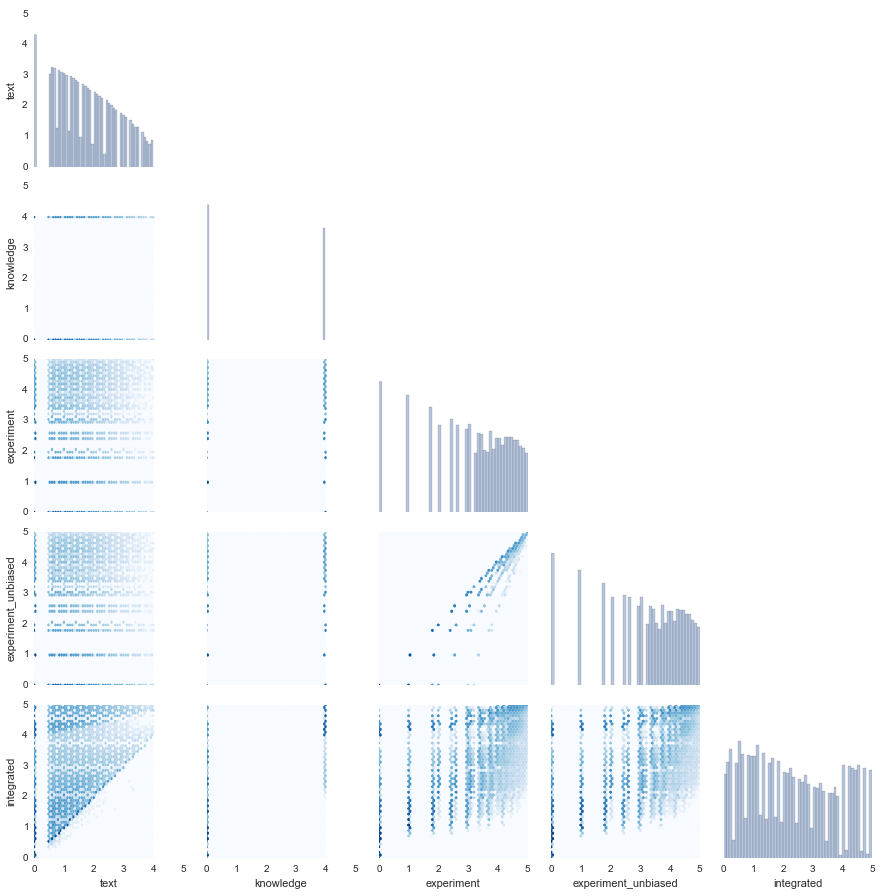

In [24]:
seaborn.set_style('white')
viz_df = master_df.iloc[:, 4:].fillna(0)
viz_df.columns = viz_df.columns.map(lambda x: x.split('_', 1)[1])
grid = seaborn.PairGrid(viz_df)
grid.map_diag(seaborn.distplot, kde=False, hist_kws={'log': True})
grid.map_lower(matplotlib.pyplot.hexbin, bins='log', cmap='Blues', gridsize=50, linewidths=0)
grid.set(xlim=(0, 5), ylim=(0, 5))
seaborn.despine(top=True, right=True, left=True, bottom=True)
grid.savefig('figure/channel-histograms.png', dpi=300)